# CITE-seq analysis with totalVI

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

- Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

In [ ]:
from scvi_colab import install

!pip install --quiet scvi-colab

install()

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi

## Imports and data loading

In [1]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 0
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/pytorch_lightning/loggers/base.py:24: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  rank_zero_deprecation(


This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.).

We run the standard workflow for keeping count and normalized data together.

In [2]:
adata = scvi.data.pbmcs_10x_cite_seq()
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                                                     
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                                      


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 10849 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch'
    uns: 'log1p'
    obsm: 'protein_expression'
    layers: 'counts'

```{important}
In this tutorial we will show totalVI's compatibility with the [MuData](https://mudata.readthedocs.io/en/latest/api/generated/mudata.MuData.html#mudata.MuData) format, which is a container for multiple AnnData objects. MuData objects can be read from the outputs of CellRanger using `muon.read_10x_h5`.

Furthermore, AnnData alone can also be used by storing the protein count data in `.obsm`, which is how it already is. For the AnnData-only workflow, see the documentation for `setup_anndata` in `scvi.model.TOTALVI`.
```

In [4]:
protein_adata = ad.AnnData(adata.obsm["protein_expression"])
protein_adata.obs_names = adata.obs_names
del adata.obsm["protein_expression"]
mdata = md.MuData({"rna": adata, "protein": protein_adata})
mdata

/tmp/ipykernel_17433/3155427964.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  protein_adata = ad.AnnData(adata.obsm["protein_expression"])
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

MuData object with n_obs × n_vars = 10849 × 15806
  2 modalities
    rna:	10849 x 15792
      obs:	'n_genes', 'percent_mito', 'n_counts', 'batch'
      uns:	'log1p'
      layers:	'counts'
    protein:	10849 x 14

In [5]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [6]:
mdata.update()

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


### Setup mudata

Now we run `setup_mudata`, which is the MuData analog to `setup_anndata`. The caveat of this workflow is that we need to provide this function which modality of the `mdata` object contains each piece of data. So for example, the batch information is in `mdata.mod["rna"].obs["batch"]`. Therefore, in the `modalities` argument below we specify that the `batch_key` can be found in the `"rna_subset"` modality of the MuData object.

Notably, we provide `protein_layer=None`. This means scvi-tools will pull information from `.X` from the modality specified in `modalities` (`"protein"` in this case). In the case of RNA, we want to use the counts, which we stored in `mdata.mod["rna"].layers["counts"]`.

In [7]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    batch_key="batch",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

```{note}
Specify the modality of each argument via the `modalities` dictionary, which maps layer/key arguments to MuData modalities.
```

## Prepare and run model

In [8]:
vae = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [9]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 363/400:  91%|█████████ | 363/400 [03:15<00:19,  1.85it/s, loss=1.21e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1241.049. Signaling Trainer to stop.


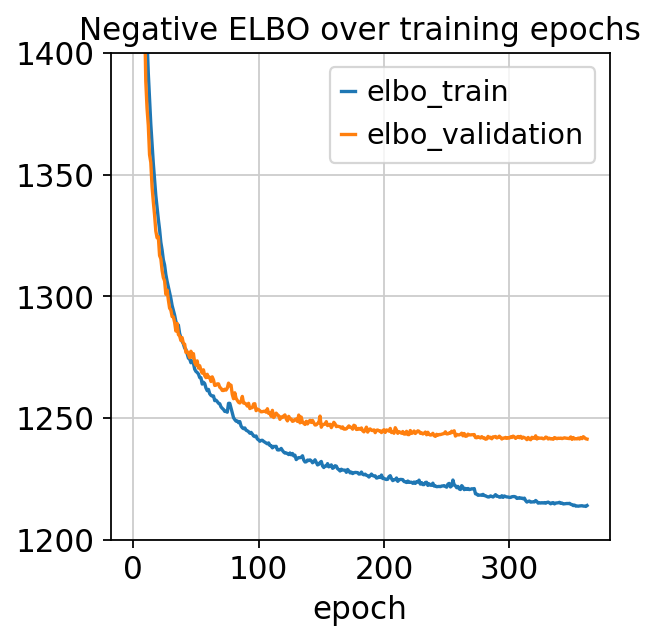

In [10]:
fig, ax = plt.subplots(1, 1)
vae.history["elbo_train"].plot(ax=ax, label="train")
vae.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 1400))
ax.legend()

## Analyze outputs

We use Scanpy and muon for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow.

In [11]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]
# arbitrarily store latent in rna modality
rna.obsm["X_totalVI"] = vae.get_latent_representation()

rna_denoised, protein_denoised = vae.get_normalized_expression(
    n_samples=25, return_mean=True, transform_batch=["PBMC10k", "PBMC5k"]
)

(
    rna.layers["denoised_rna"],
    protein.layers["denoised_protein"],
) = (rna_denoised, protein_denoised)

protein.layers["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, return_mean=True, transform_batch=["PBMC10k", "PBMC5k"]
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


Now we can compute clusters and visualize the latent space.

In [12]:
sc.pp.neighbors(rna, use_rep="X_totalVI")
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="leiden_totalVI")

In [13]:
mdata.update()

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


We can now use muon plotting functions which can pull data from either modality of the MuData object.

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


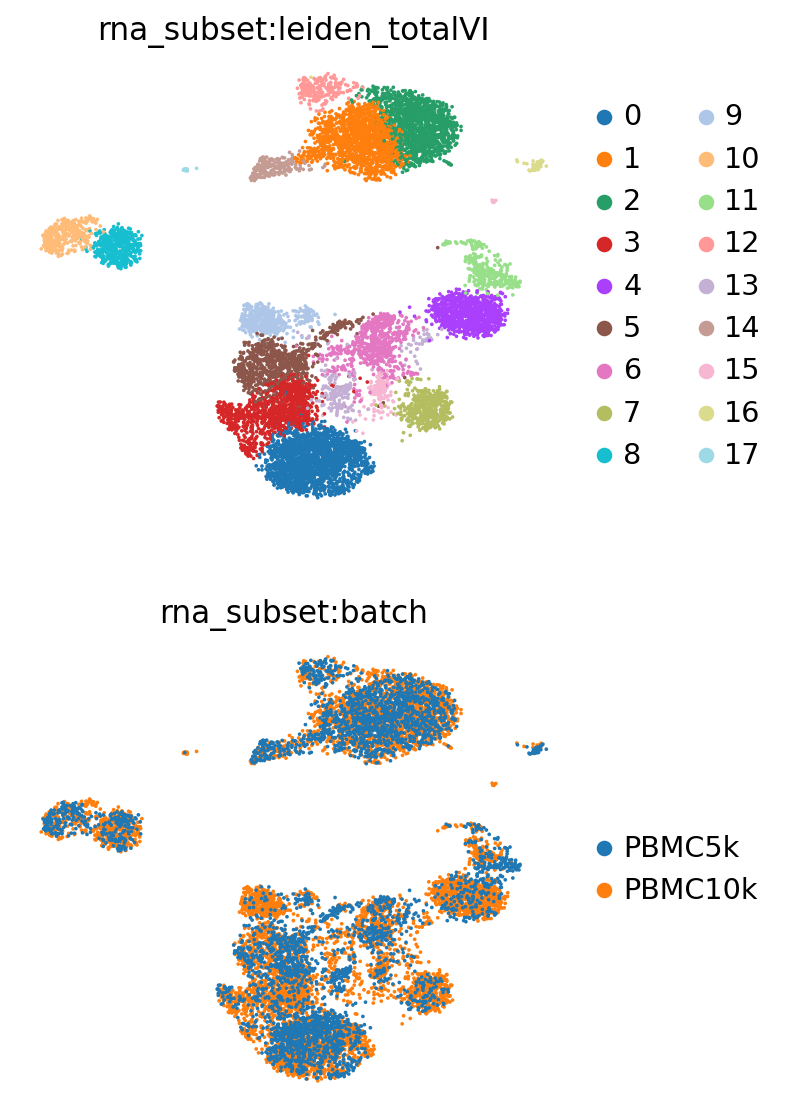

In [14]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color=["rna_subset:leiden_totalVI", "rna_subset:batch"],
    frameon=False,
    ncols=1,
)

### Visualize denoised protein values

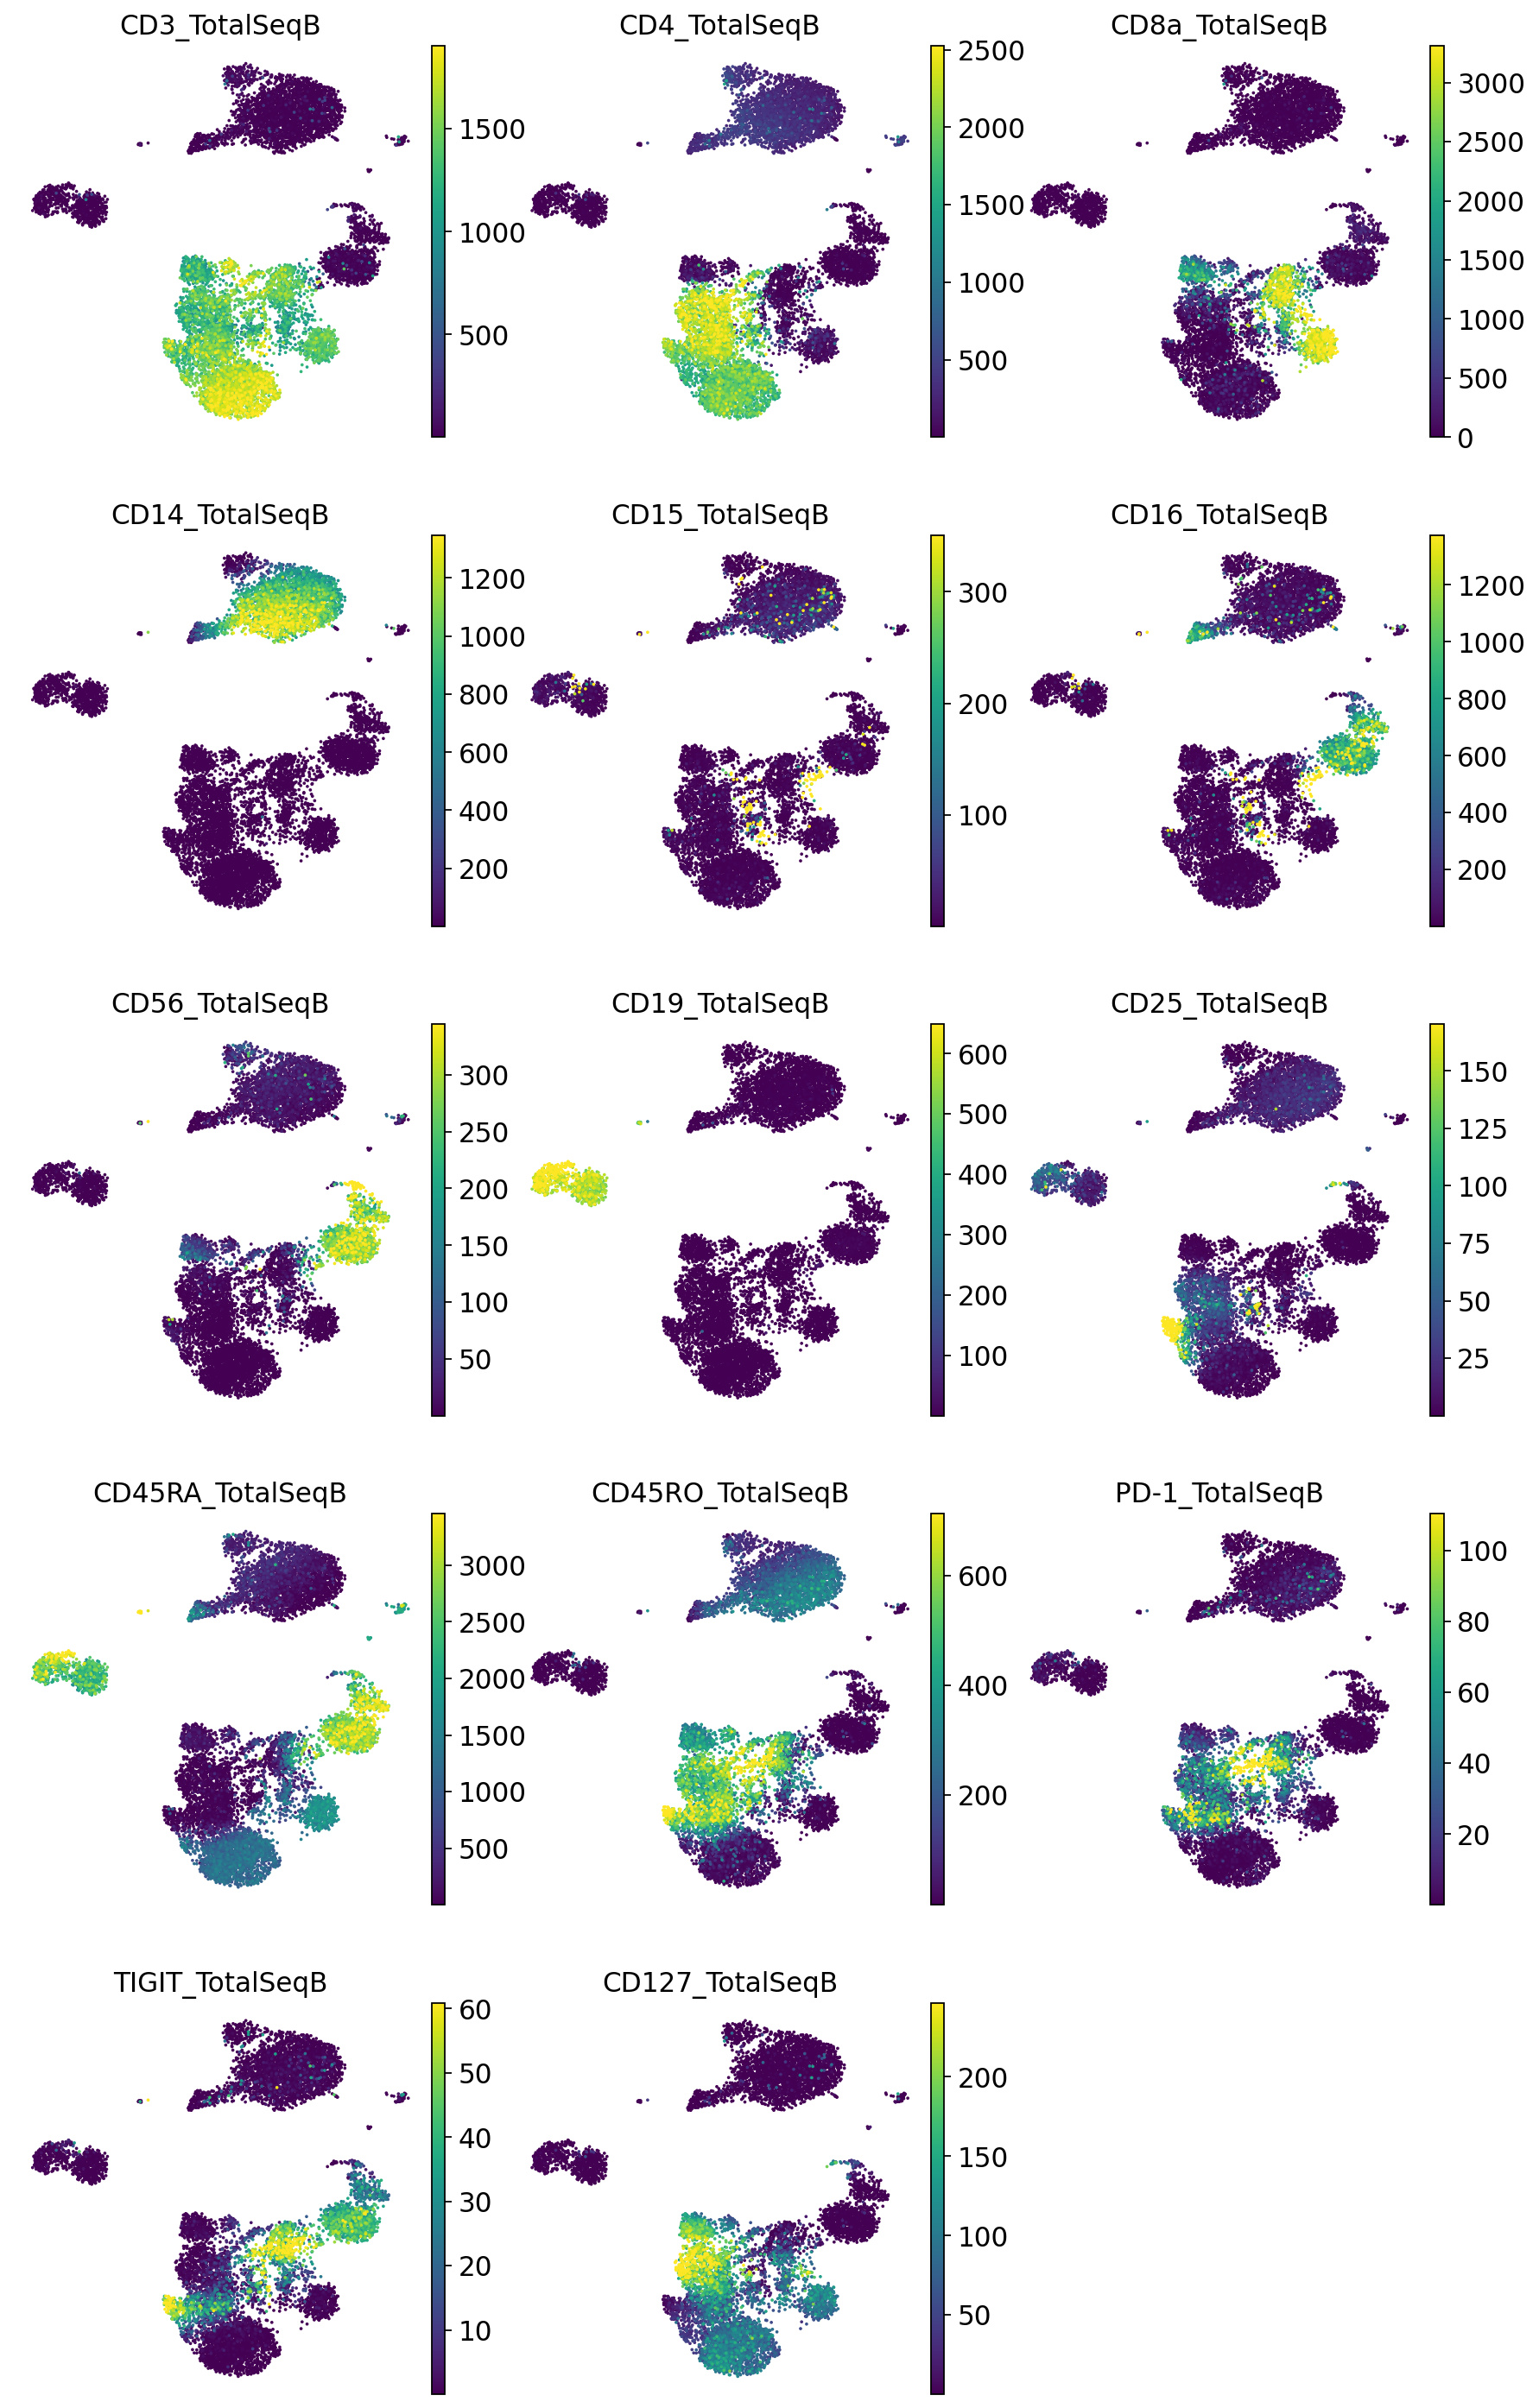

In [15]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="denoised_protein",
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

```{note}
While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.
```

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

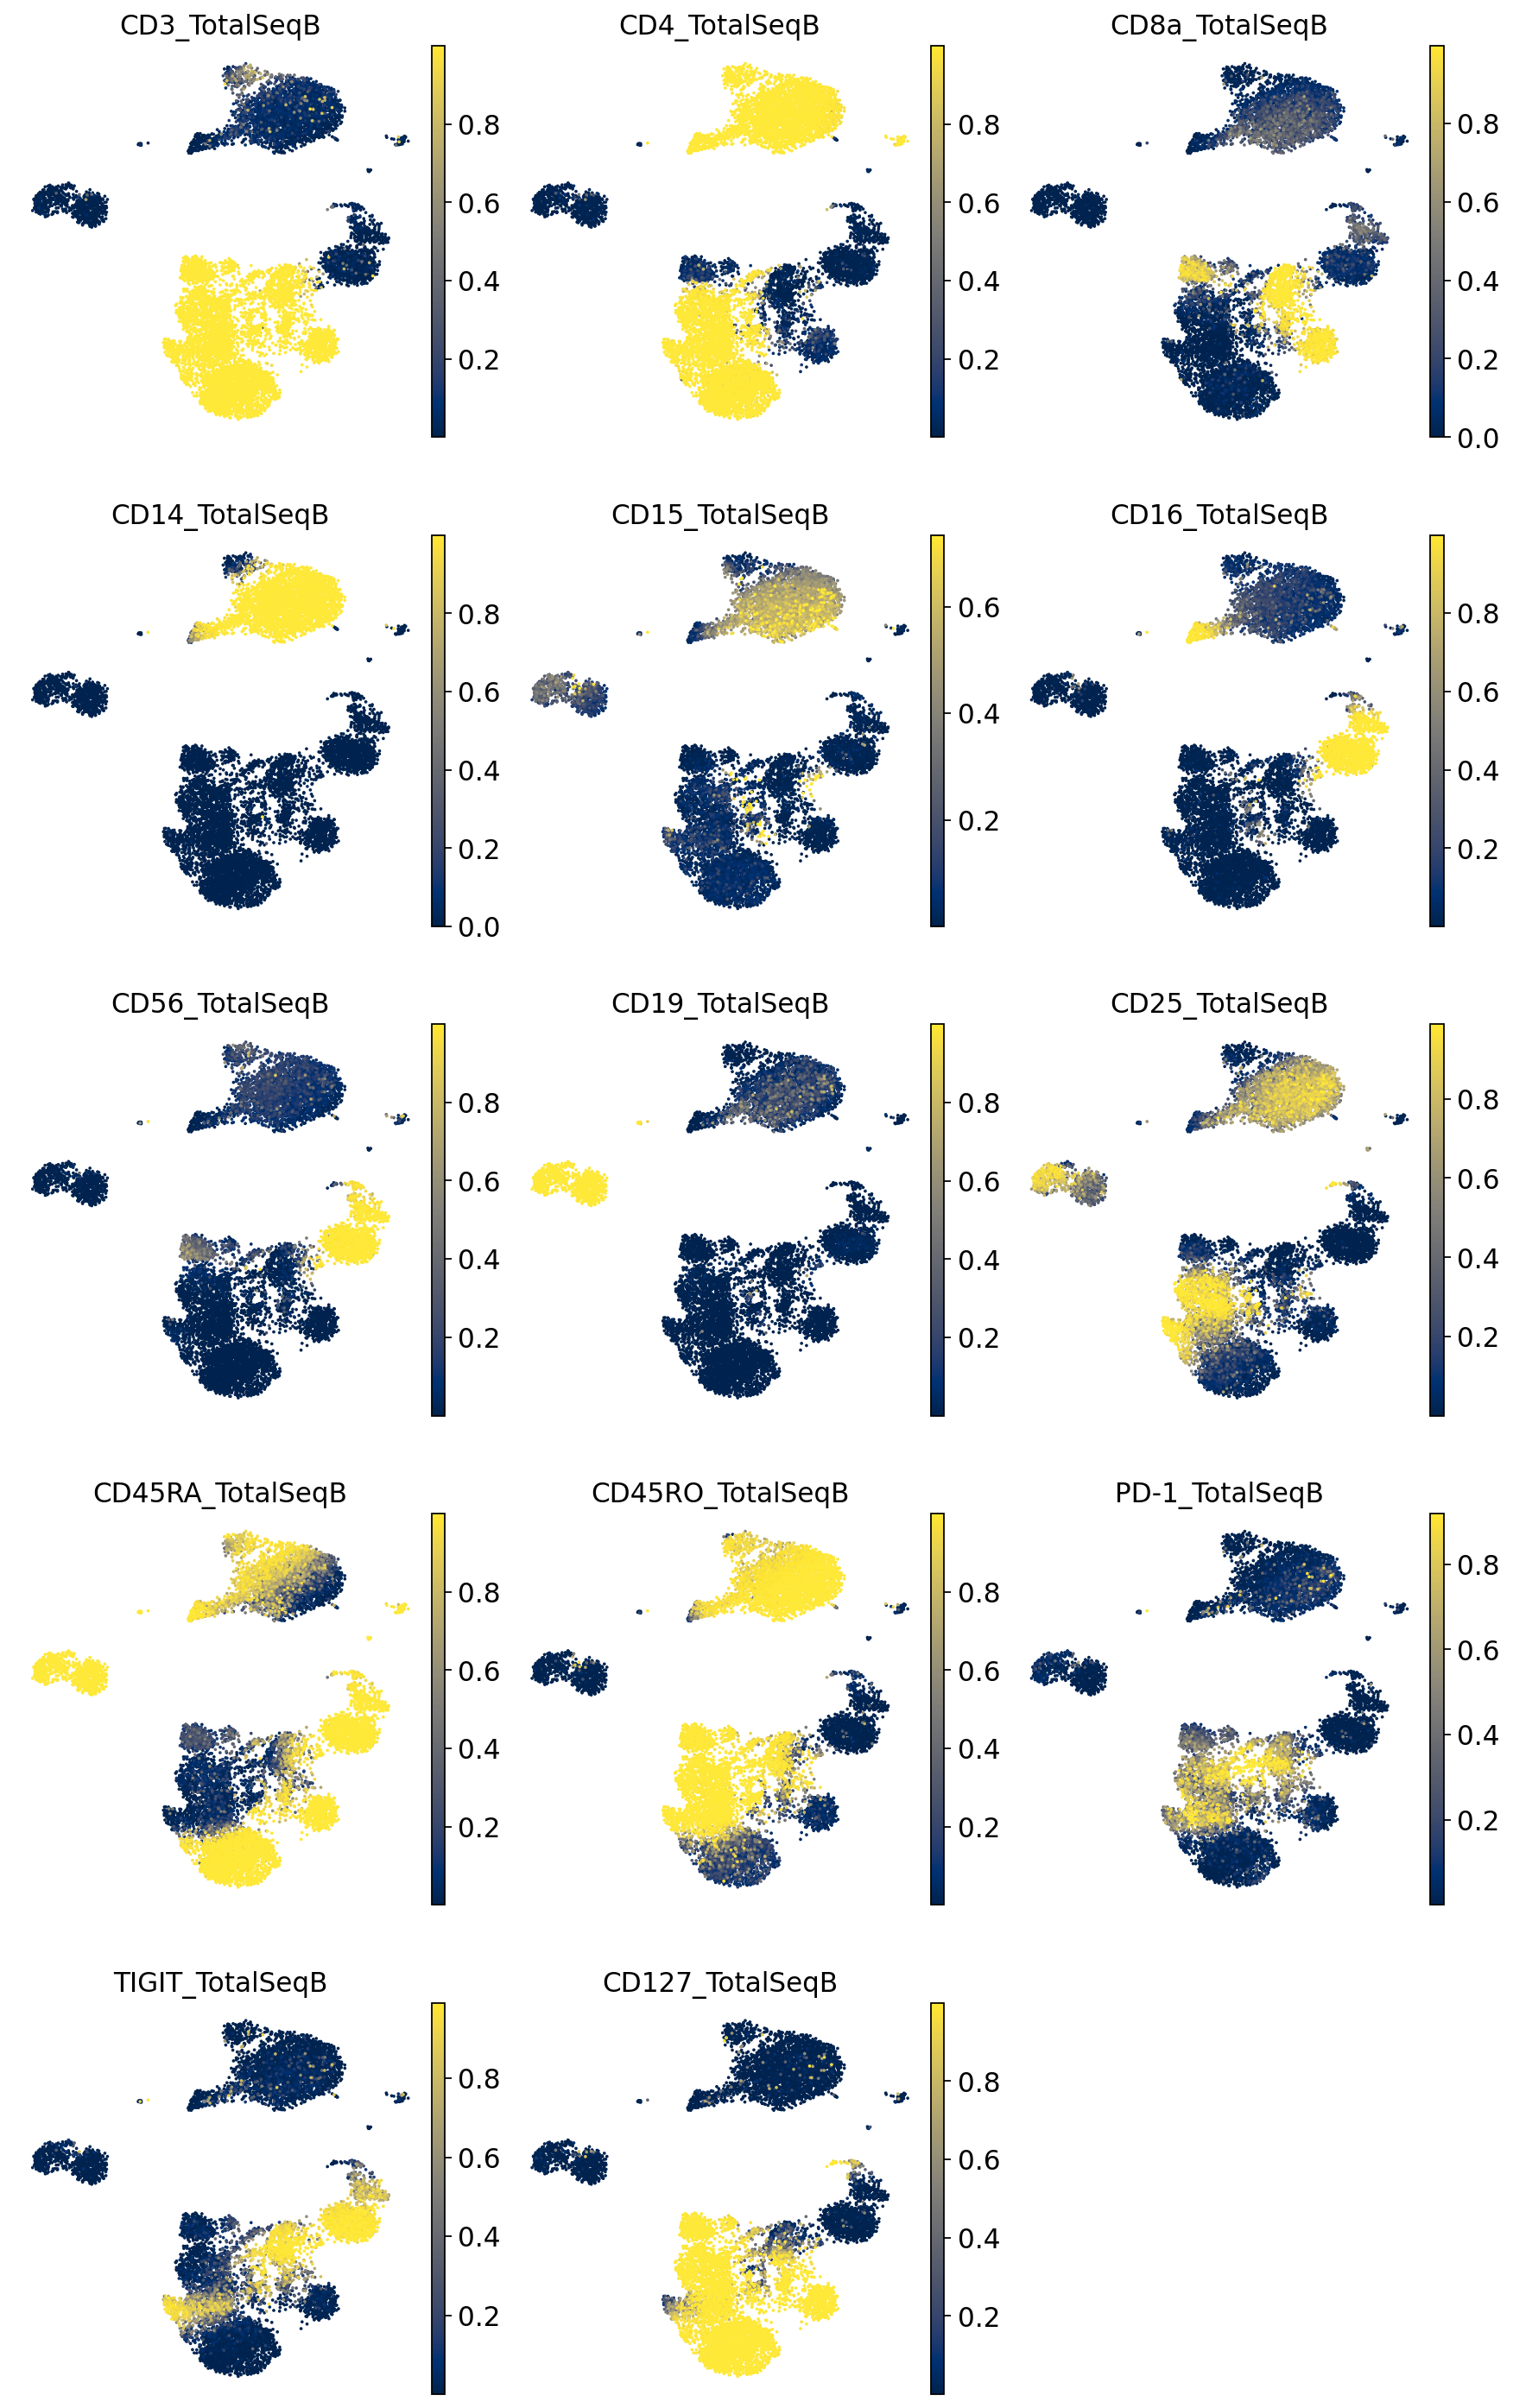

In [16]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    layer="protein_foreground_prob",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    color_map="cividis",
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

```{important}
We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.
```

In [17]:
de_df = vae.differential_expression(
    groupby="rna_subset:leiden_totalVI", delta=0.5, batch_correction=True
)
de_df.head(5)

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:   6%|▌         | 1/18 [00:01<00:17,  1.03s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  11%|█         | 2/18 [00:02<00:16,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  17%|█▋        | 3/18 [00:03<00:15,  1.02s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  22%|██▏       | 4/18 [00:04<00:14,  1.02s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  28%|██▊       | 5/18 [00:05<00:13,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  33%|███▎      | 6/18 [00:06<00:12,  1.00s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  39%|███▉      | 7/18 [00:07<00:11,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  44%|████▍     | 8/18 [00:08<00:10,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  50%|█████     | 9/18 [00:09<00:09,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  56%|█████▌    | 10/18 [00:10<00:08,  1.00s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  61%|██████    | 11/18 [00:11<00:07,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  67%|██████▋   | 12/18 [00:12<00:06,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  72%|███████▏  | 13/18 [00:13<00:05,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  78%|███████▊  | 14/18 [00:14<00:04,  1.00s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  83%|████████▎ | 15/18 [00:15<00:02,  1.00it/s]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  89%|████████▉ | 16/18 [00:16<00:02,  1.00s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...:  94%|█████████▍| 17/18 [00:17<00:01,  1.01s/it]

/home/adam/Documents/software/scvi-tools/scvi/model/_totalvi.py:1066: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  warnings.warn(


DE...: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
C9ORF139    0.9734        0.0266      3.599884  5.925353e-07  0.000043   
ASCL2       0.9726        0.0274      3.569430  4.377473e-07  0.000114   
HLA-DQA2    0.9706        0.0294      3.496919  1.478030e-06  0.000273   
REG4        0.9700        0.0300      3.476098  4.301558e-06  0.000001   
ADTRP       0.9682        0.0318      3.415972  1.013814e-04  0.000009   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
C9ORF139           0.0    0.5 -5.723970   -6.055791  3.122658  ...   0.000526   
ASCL2              0.0    0.5 -7.013683   -7.373041  3.694981  ...   0.000000   
HLA-DQA2           0.0    0.5 -6.050211   -6.293546  3.877910  ...   0.000000   
REG4               0.0    0.5  5.233232    5.638005  3.539875  ...   0.007891   
ADTRP              0.0    0.5  6.716998    7.128677  3.925131  ...   0.163072   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
C9ORF139   0.075324               0.000526               0.067054   
ASCL2      0.187193               0.000000               0.142713   
HLA-DQA2   0.581024               0.000000               0.186746   
REG4       0.004135               0.007365               0.003800   
ADTRP      0.010393               0.139400               0.008829   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
C9ORF139              0.003434              0.433609            True   
ASCL2                 0.000000              1.200019            True   
HLA-DQA2              0.000000              3.187069            True   
REG4                  0.084258              0.040130            True   
ADTRP                 1.981167              0.120156            True   

          comparison  group1 group2  
C9ORF139   0 vs Rest       0   Rest  
ASCL2      0 vs Rest       0   Rest  
HLA-DQA2   0 vs Rest       0   Rest  
REG4       0 vs Rest       0   Rest  
ADTRP      0 vs Rest       0   Rest  

[5 rows x 22 columns]

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [19]:
filtered_pro = {}
filtered_rna = {}
cats = rna.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains("TotalSeqB")
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

We can also use general scanpy visualization functions

In [21]:
sc.tl.dendrogram(rna, groupby="leiden_totalVI", use_rep="X_totalVI")
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs["leiden_totalVI"] = rna.obs["leiden_totalVI"]
protein.obsm["X_totalVI"] = rna.obsm["X_totalVI"]
sc.tl.dendrogram(protein, groupby="leiden_totalVI", use_rep="X_totalVI")

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


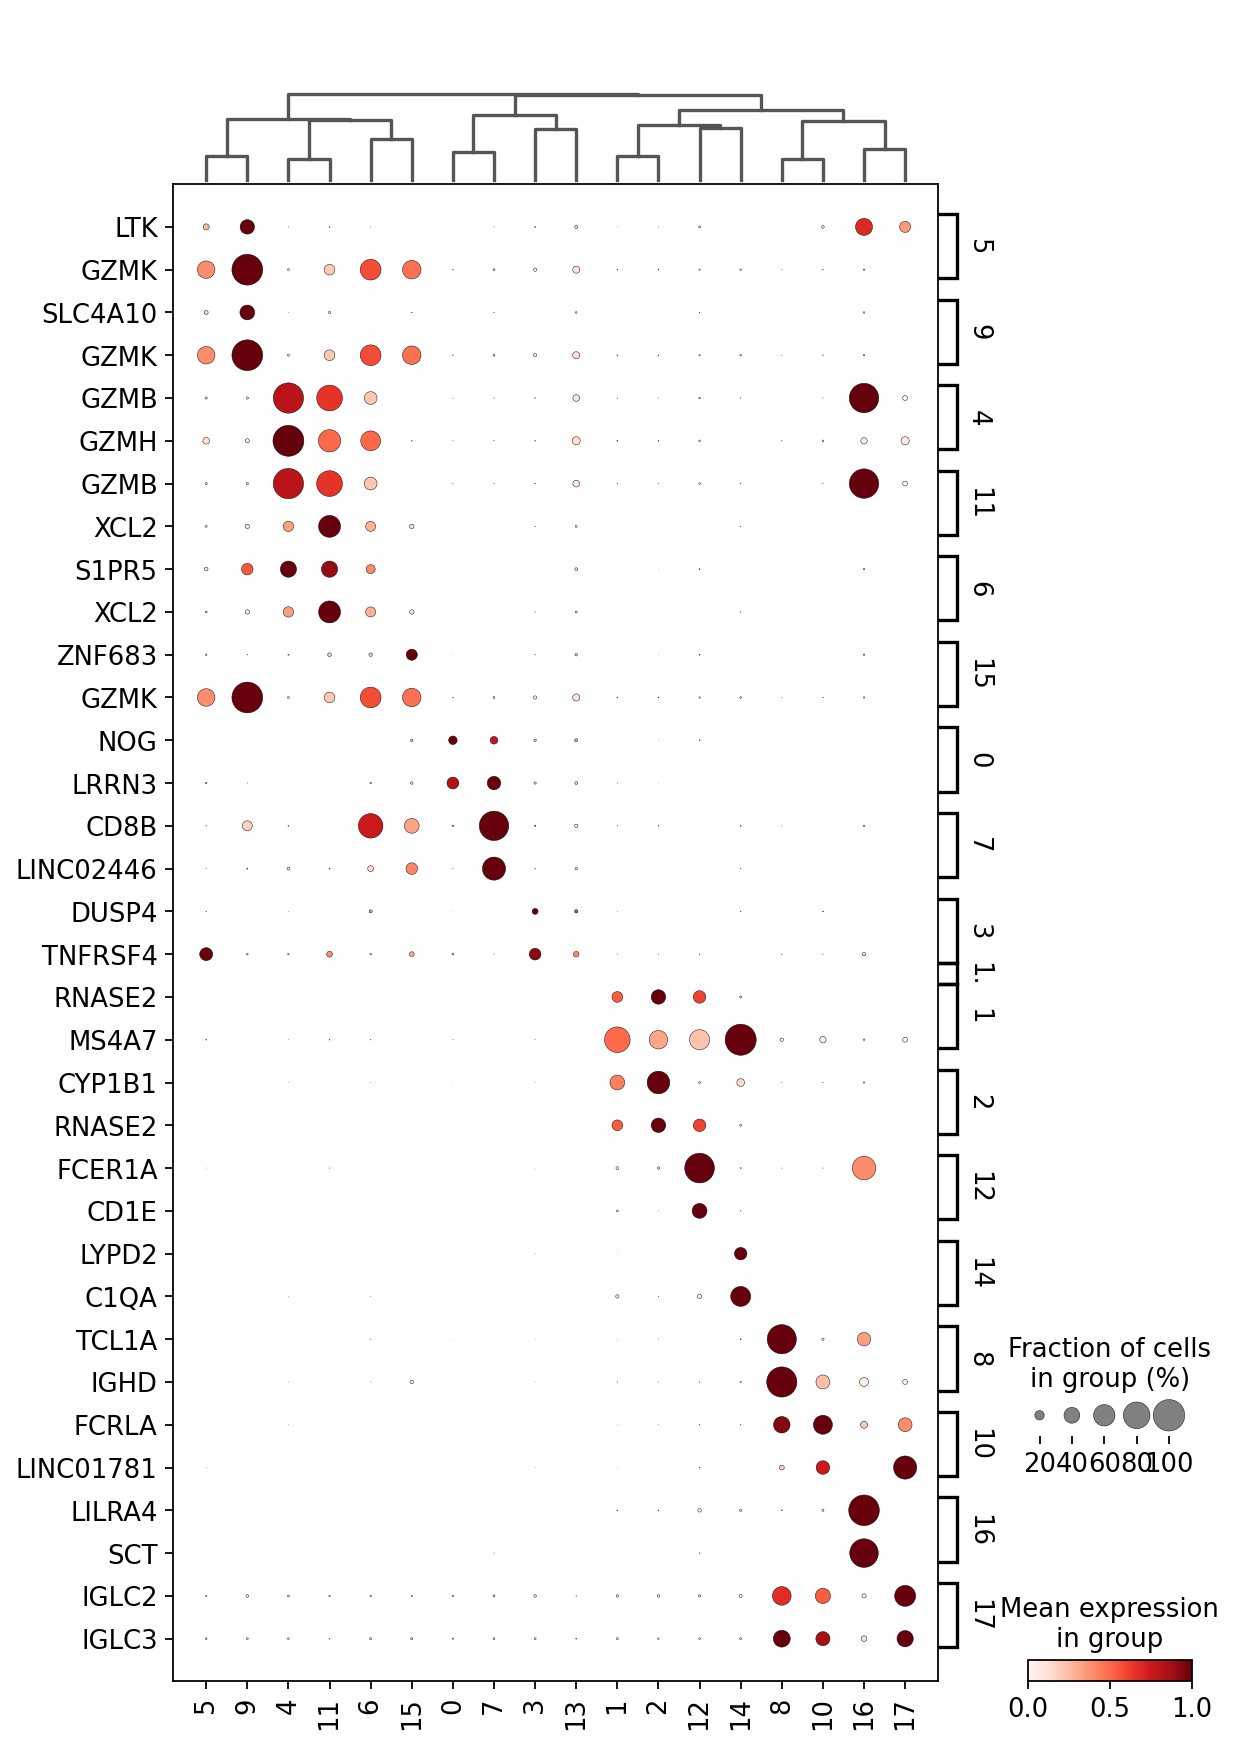

In [22]:
sc.pl.dotplot(
    rna,
    filtered_rna,
    groupby="leiden_totalVI",
    dendrogram=True,
    standard_scale="var",
    swap_axes=True,
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

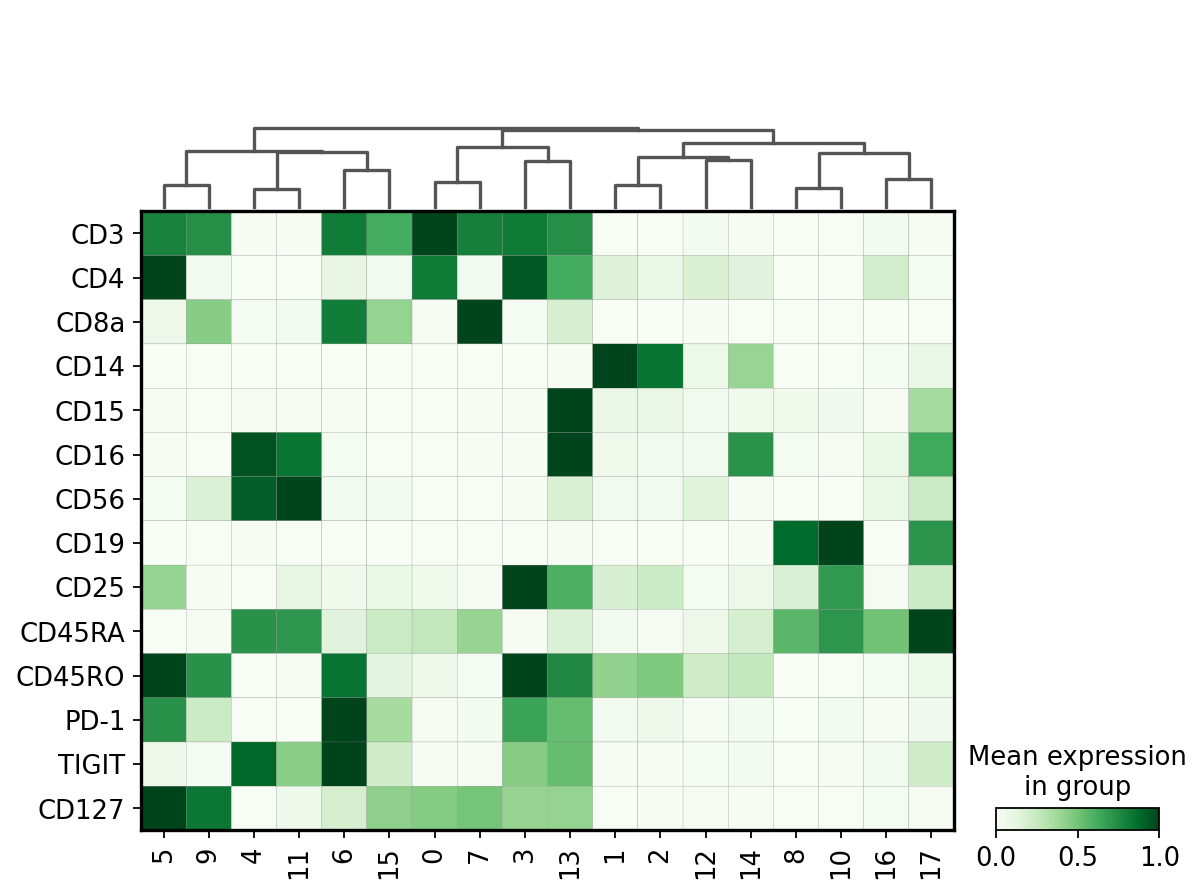

In [23]:
sc.pl.matrixplot(
    protein,
    protein.var["clean_names"],
    groupby="leiden_totalVI",
    gene_symbols="clean_names",
    dendrogram=True,
    swap_axes=True,
    layer="denoised_protein",
    cmap="Greens",
    standard_scale="var",
)

This is a selection of some of the markers that turned up in the RNA DE test.

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


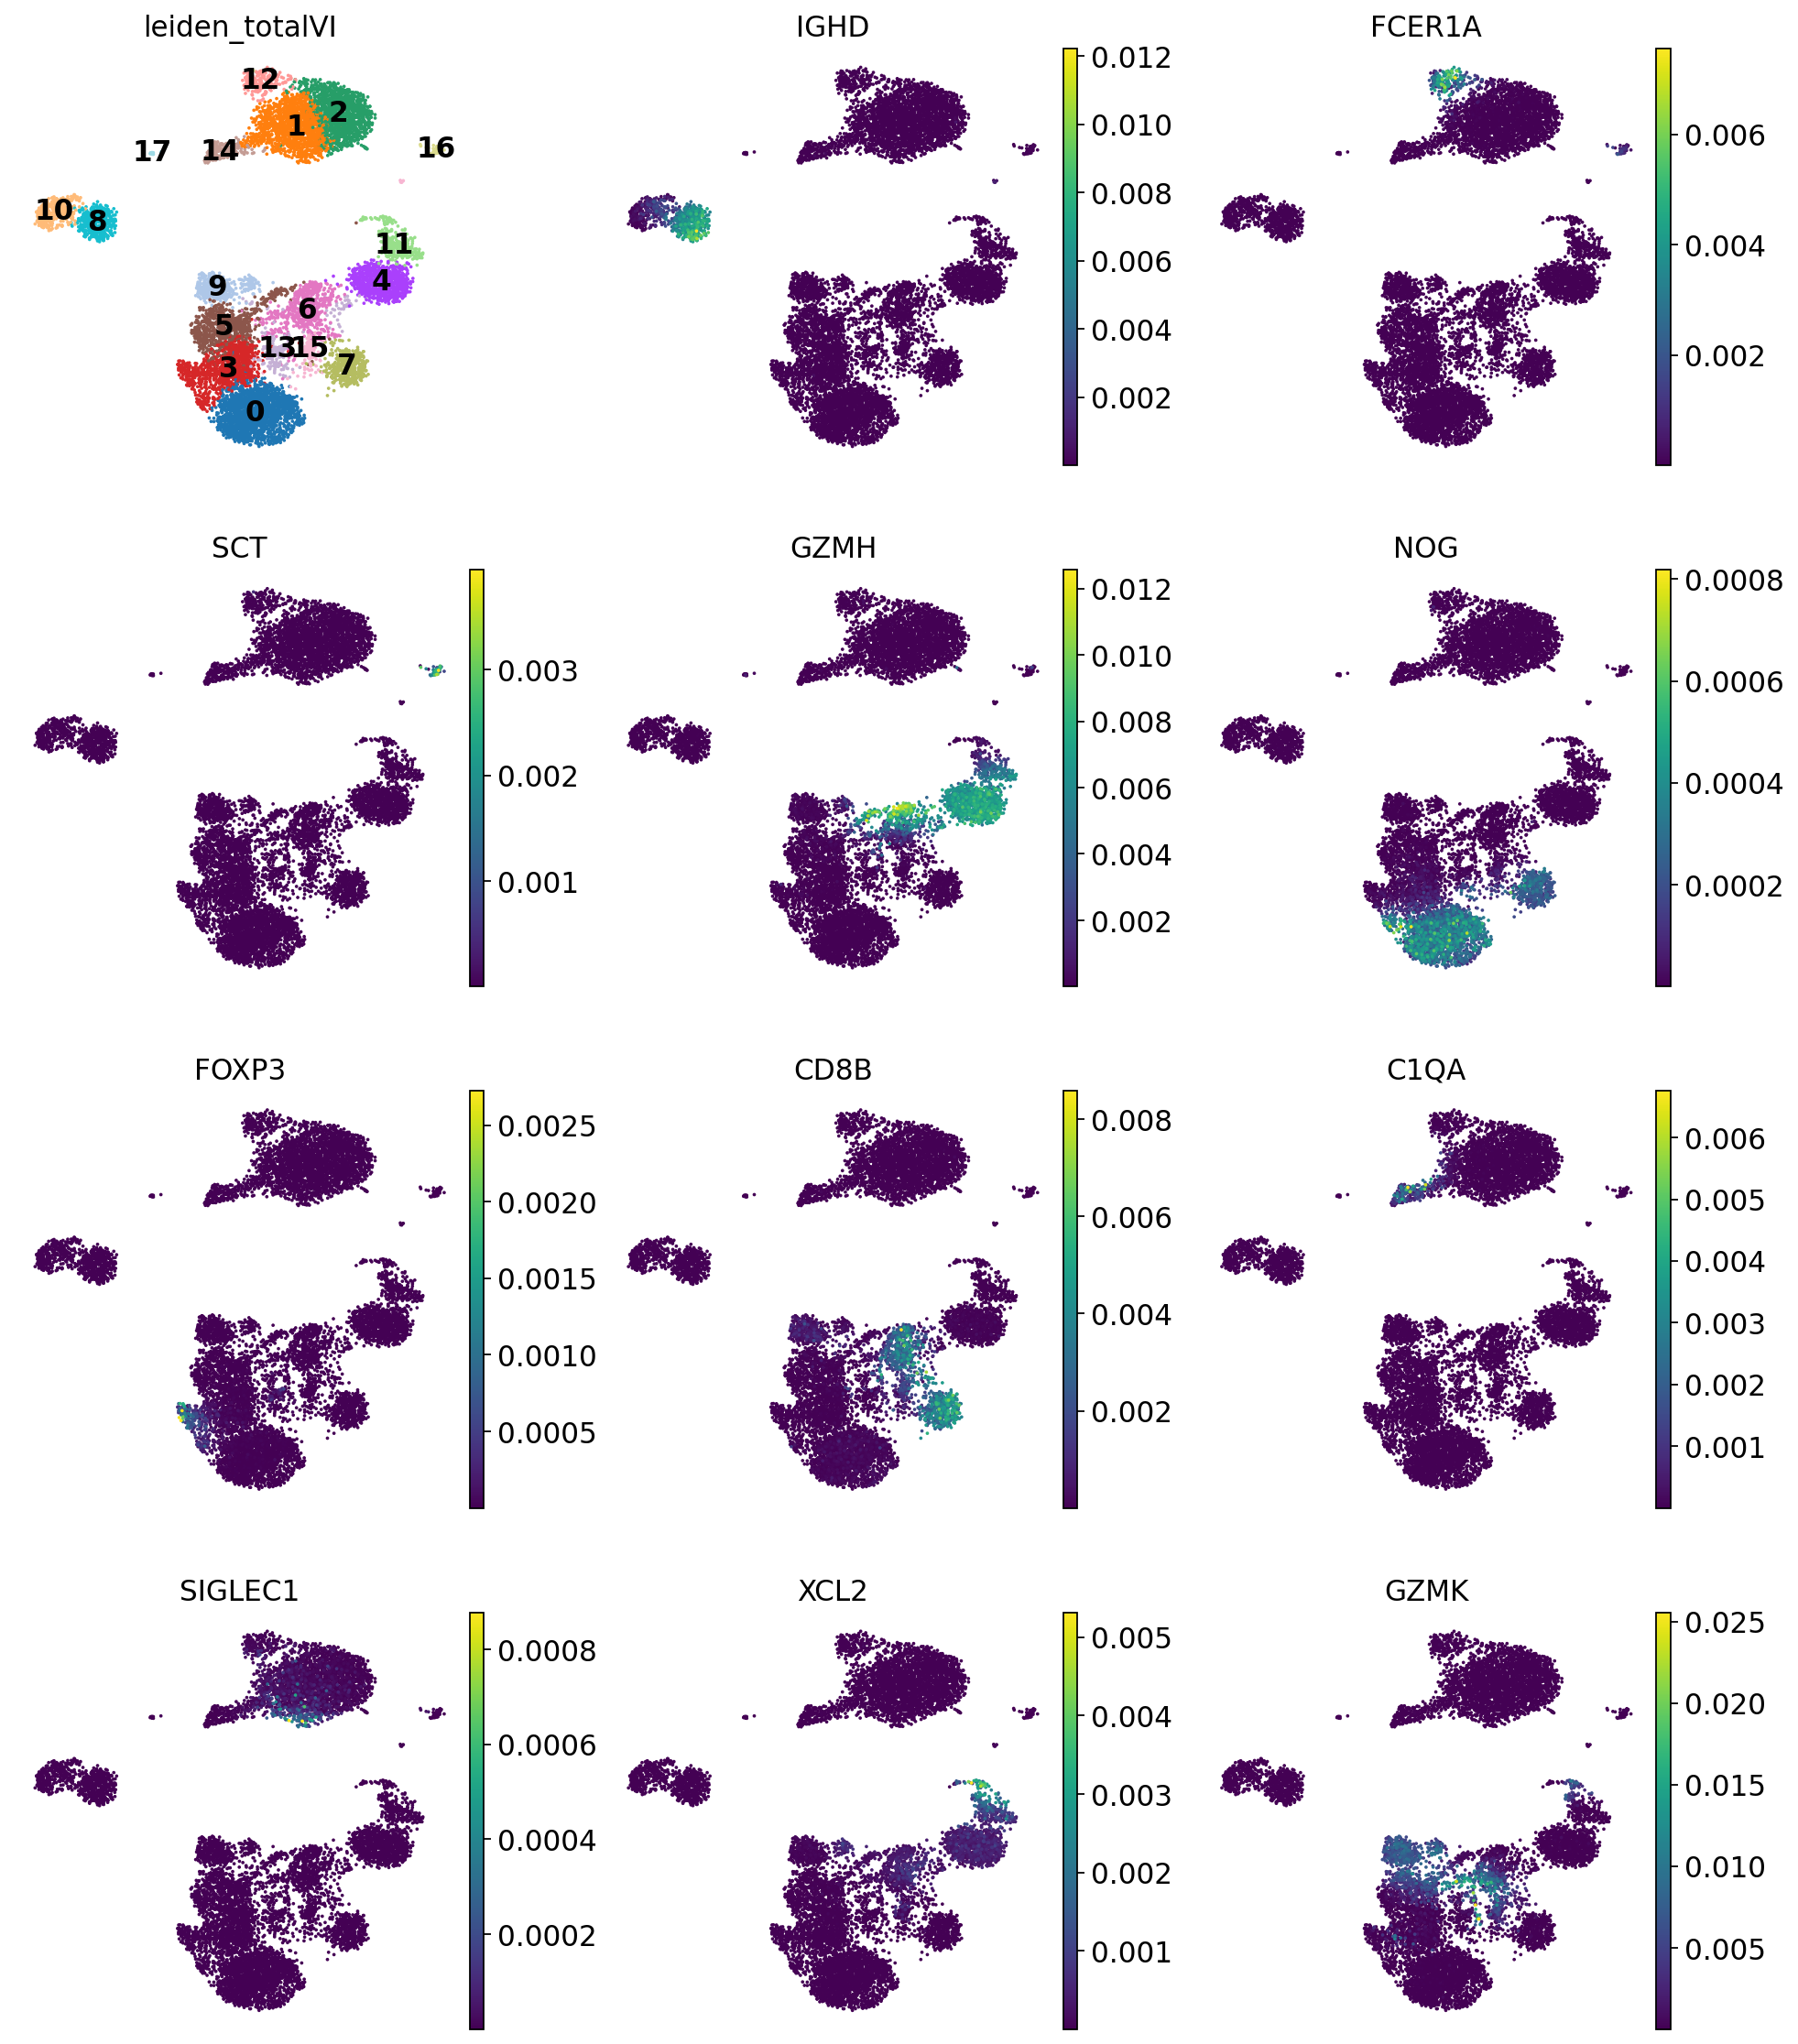

In [24]:
sc.pl.umap(
    rna,
    color=[
        "leiden_totalVI",
        "IGHD",
        "FCER1A",
        "SCT",
        "GZMH",
        "NOG",
        "FOXP3",
        "CD8B",
        "C1QA",
        "SIGLEC1",
        "XCL2",
        "GZMK",
    ],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.2,
)